# <center><strong>PROBLEM SET 3</strong></center>
### <center>Milton Straw --- ECON 815: Topics in Microeconomics --- Fall 2019</center>

In [33]:
# Import necessary packages
import pandas as pd
import numpy as np
import scipy.optimize as opt
import scipy.stats as stats
import statsmodels.api as sm
import time
import matplotlib.pyplot as plt

In [5]:
# Read in the data provided
hw_data = pd.read_stata(
    'PS3_data.dta')
hw_data.head()

,id68,year,intid,relhh,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,...,redpregovinc,hsex,wsex,age,wage,hpersno,wpersno,hyrsed,wyrsed,pce
0,1,1967,1,Head,1200.0,2000.0,NaN,NaN,0,NaN,...,5614.0,1.0,2.0,52.0,46.0,1.0,2.0,8.0,8.0,0.0
1,2,1967,2,Head,0.0,0.0,NaN,NaN,0,NaN,...,0.0,1.0,2.0,56.0,57.0,1.0,2.0,3.0,3.0,0.0
2,3,1967,3,Head,0.0,0.0,NaN,NaN,0,NaN,...,0.0,1.0,2.0,77.0,64.0,1.0,2.0,NaN,3.0,0.0
3,4,1967,4,Head,1560.0,0.0,NaN,NaN,6,1.0,...,3280.0,1.0,2.0,45.0,44.0,1.0,2.0,8.0,5.0,0.0
4,5,1967,5,Head,2500.0,2000.0,NaN,NaN,3,1.0,...,7900.0,1.0,2.0,24.0,22.0,1.0,2.0,10.0,9.0,0.0


### Clean the Data

In [36]:
# Clean the data

# Describe hourly wage as labor income of head divided by annual hours worked of head, and describe log wage
hw_data['hrwage'] = hw_data.hlabinc / hw_data.hannhrs
hw_data['lwage'] = np.log(hw_data['hrwage'])

# Create necessary indicator and dummy variables
hw_data['Black'] = (hw_data['hrace'] == 2).astype(int)
hw_data['Hispanic'] = (hw_data['hrace'] == 5).astype(int)
hw_data['OtherRace'] = (hw_data['hrace'] != 1) & (hw_data['hrace'] != 2) & (hw_data['hrace'] != 5).astype(int)
hw_data['cons'] = 1
minAge = 25
maxAge = 60
minWage = 7.0

# Drop if missing value for the wage, education, or race
hw_data = hw_data[hw_data.hlabinc.isnull() != True ]
hw_data = hw_data[hw_data.hannhrs.isnull() != True ]
hw_data = hw_data[hw_data.hyrsed.isnull() != True ]
hw_data = hw_data[hw_data.hrace.isnull() != True ]
hw_data = hw_data[hw_data.hrwage != np.inf ]

# Select only male heads of household who are between 25 and 60 years of age and earn wages > $7/hr. 
hw_data = hw_data[(hw_data.hsex == 1.0) & (hw_data.age >= minAge) & (hw_data.age <= maxAge) & (hw_data.hrwage > minWage) ]

year1df = hw_data[hw_data.year == 1971]
year2df = hw_data[hw_data.year == 1980]
year3df = hw_data[hw_data.year == 1990]
year4df = hw_data[hw_data.year == 2000]

hw_data.head()

,id68,year,intid,relhh,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,...,wpersno,hyrsed,wyrsed,pce,hrwage,lwage,Black,Hispanic,OtherRace,cons
11161,402,1971,1,Head,1523.0,0.0,62928.707031,NaN,0,1.0,...,2.0,12.0,12.0,0.247121,41.318916,3.721320,0,0,False,1
11164,461,1971,4,Head,2010.0,0.0,22660.970703,NaN,0,1.0,...,2.0,5.0,5.0,0.247121,11.274115,2.422509,0,0,False,1
11166,1126,1971,8,Head,2860.0,0.0,29337.865234,NaN,1,NaN,...,2.0,16.0,12.0,0.247121,10.257995,2.328057,0,0,False,1
11173,284,1971,20,Head,2400.0,0.0,76885.437500,NaN,2,1.0,...,2.0,16.0,12.0,0.247121,32.035599,3.466848,0,0,False,1
11175,50,1971,29,Head,3164.0,2000.0,31968.156250,28326.214844,3,1.0,...,2.0,12.0,12.0,0.247121,10.103716,2.312903,0,0,False,1


In [7]:
hw_data.describe()

,id68,year,intid,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,hrace,...,hpersno,wpersno,hyrsed,wyrsed,pce,hrwage,lwage,Black,Hispanic,cons
count,57062.000000,57062.000000,57062.000000,57062.000000,57062.000000,5.706200e+04,37133.000000,57062.000000,51693.000000,57062.000000,...,57062.000000,49775.000000,57062.000000,49425.000000,57062.000000,57062.000000,57062.000000,57062.000000,57062.0,57062.0
mean,1507.470558,1986.575672,3480.375311,2228.557617,991.441406,5.282805e+04,23073.908203,1.173566,1.086298,1.101416,...,58.632908,68.006027,13.529967,13.209712,0.616109,24.320921,3.010804,0.056377,0.0,1.0
std,828.361439,8.712311,2253.229068,620.054077,926.178162,5.236477e+04,20998.779297,1.216918,0.343691,0.369015,...,78.453896,81.718880,2.450013,2.163211,0.206353,25.209909,0.544096,0.230651,0.0,0.0
min,1.000000,1971.000000,1.000000,2.000000,0.000000,1.666980e+01,1.192780,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.247121,7.000252,1.945946,0.000000,0.0,1.0
25%,782.000000,1979.000000,1690.000000,1952.000000,0.000000,3.037345e+04,8895.574219,0.000000,1.000000,1.000000,...,1.000000,2.000000,12.000000,12.000000,0.421747,13.950662,2.635527,0.000000,0.0,1.0
50%,1542.000000,1987.000000,3296.000000,2160.000000,953.299988,4.382858e+04,19498.349609,1.000000,1.000000,1.000000,...,4.000000,4.000000,13.000000,12.000000,0.635834,19.914677,2.991457,0.000000,0.0,1.0
75%,2225.000000,1994.000000,5002.000000,2519.000000,1900.000000,6.138495e+04,31769.908203,2.000000,1.000000,1.000000,...,170.000000,170.000000,16.000000,15.000000,0.803488,27.790929,3.324710,0.000000,0.0,1.0
max,2930.000000,2002.000000,16968.000000,5840.000000,5840.000000,3.771521e+06,417271.468750,11.000000,8.000000,3.000000,...,227.000000,230.000000,17.000000,17.000000,0.928007,1717.330322,7.448526,1.000000,0.0,1.0


In [8]:
hw_data.hrace.unique()

array([1., 2., 3.])

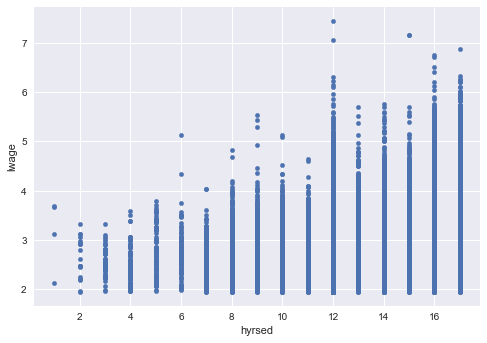

In [9]:
%matplotlib inline
plt.style.use('seaborn')

hw_data.plot(x='hyrsed', y='lwage', kind='scatter')
plt.show()

In [51]:
y = np.array(year1df['lwage']).astype('float')
b1 = np.array(year1df['hyrsed']).astype('float')
b2 = np.array(year1df['age']).astype('float')
b3 = np.array(year1df['Black']).astype('float')
b4 = np.array(year1df['Hispanic']).astype('float')
b5 = np.array(year1df['OtherRace']).astype('float')

nrow = b1.shape[0]
intercept = np.ones((nrow, 1))
x = np.column_stack((intercept, b1, b2, b3, b5))

# Hispanic is not included in the X matrix created above because there are no observations.

### Estimate the model via MLE

In [28]:
def model_mle(params):
    '''
    Args:
    
    Returns:
    '''
    
    cons = params[0]
    beta1 = params[1]
    beta2 = params[2]
    beta3 = params[3]
    beta4 = params[4]
    beta5 = params[5]
    
    beta = [beta1, beta2, beta3, beta4, beta5]
    
    yPred = np.dot(x, beta)
    
    # Define age range - ages 25-60, inclusive is 36 years
    # ageRange = maxAge - minAge +1
    
    #lwage = cons + beta1 * hw_data['hyrsed'] + beta2 * hw_data['age'] + beta3 * hw_data['Black'] + beta4 * hw_data['Hispanic'] + beta5 * hw_data['OtherRace']
    
    negll = -np.sum(stats.norm.logpdf(y, loc=yPred))
    
    return negll

In [29]:
# List of initial parameter guesses.

initGuess = [1, 0.6, 0, 0.5, 1, 0.5]

### MLE for 1971

In [19]:
resultsyear1 = opt.minimize(model_mle, initGuess, method='Nelder-Mead', tol = 1e-10, options={'maxiter': 5000})

print(resultsyear1.x)

[1.  0.6 0.  0.5 1.  0.5]


### OLS for 1971 ~ Compare to above MLE

In [53]:
Y = year1df['lwage']
X = year1df[['cons', 'hyrsed', 'age', 'Black', 'Hispanic', 'OtherRace']]

OLSresultsyear1 = sm.OLS(endog = Y, exog = X, missing = 'drop').fit()
print(OLSresultsyear1.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

### MLE for 1980

In [48]:
y = np.array(year2df['lwage']).astype('float')
b1 = np.array(year2df['hyrsed']).astype('float')
b2 = np.array(year2df['age']).astype('float')
b3 = np.array(year2df['Black']).astype('float')
b4 = np.array(year2df['Hispanic']).astype('float')
b5 = np.array(year2df['OtherRace']).astype('float')

nrow = b1.shape[0]
intercept = np.ones((nrow, 1))
x = np.column_stack((intercept, b1, b2, b3, b5))

resultsyear2 = minimize(model_mle, initGuess, method='Nelder-Mead', tol = 1e-10, options={'maxiter': 5000})

print(resultsyear2.x)

[-0.47156277  1.61308834  0.06755585  0.01269854 -0.10273617  0.01351128]


### MLE for 1990

In [49]:
y = np.array(year3df['lwage']).astype('float')
b1 = np.array(year3df['hyrsed']).astype('float')
b2 = np.array(year3df['age']).astype('float')
b3 = np.array(year3df['Black']).astype('float')
b4 = np.array(year3df['Hispanic']).astype('float')
b5 = np.array(year3df['OtherRace']).astype('float')

nrow = b1.shape[0]
intercept = np.ones((nrow, 1))
x = np.column_stack((intercept, b1, b2, b3, b5))

resultsyear3 = minimize(model_mle, initGuess, method='Nelder-Mead', tol = 1e-10, options={'maxiter': 5000})

print(resultsyear3.x)

[-2.25626452e+01  1.11858492e+00  9.75580782e-02  1.34656045e-02
 -1.72024265e-01 -5.97124756e-02]


### MLE for 2000

In [50]:
y = np.array(year4df['lwage']).astype('float')
b1 = np.array(year4df['hyrsed']).astype('float')
b2 = np.array(year4df['age']).astype('float')
b3 = np.array(year4df['Black']).astype('float')
b4 = np.array(year4df['Hispanic']).astype('float')
b5 = np.array(year4df['OtherRace']).astype('float')

nrow = b1.shape[0]
intercept = np.ones((nrow, 1))
x = np.column_stack((intercept, b1, b2, b3, b5))

resultsyear4 = minimize(model_mle, initGuess, method='Nelder-Mead', tol = 1e-10, options={'maxiter': 5000})

print(resultsyear4.x)

[-6.07395913  1.16169071  0.10915437  0.01099353 -0.24604483 -0.06073246]


### Comparison

In [52]:
print(resultsyear1.x)
print(resultsyear2.x)
print(resultsyear3.x)
print(resultsyear4.x)

[1.  0.6 0.  0.5 1.  0.5]
[-0.47156277  1.61308834  0.06755585  0.01269854 -0.10273617  0.01351128]
[-2.25626452e+01  1.11858492e+00  9.75580782e-02  1.34656045e-02
 -1.72024265e-01 -5.97124756e-02]
[-6.07395913  1.16169071  0.10915437  0.01099353 -0.24604483 -0.06073246]


In [54]:
### This was an attempt to make a graphical represenatation, but I didn't get to function because I was trying to unbreak everything above.

# plt.rcParams.update({'font.size': 16})

# x_axis = []
# for i in range(len(coefs)):
    # x_axis.append(coefs[i][1]*100)
# x_axis = np.array(x_axis)
# y_axis = np.array(['1971', '1980', '1990', '2000'])

# fig = plt.figure(figsize=(20,10))
# fig.suptitle('Returns to Education Over Time', font.size=24, fontweight='bold')
# ax = fig.add_subplot(111)
# ax.set_xlabel('Year')
# ax.set_ylabel('%Change in Wage from 1yr Addtl. Education')
# ax.plot(y_axis, x_axis)
# plt.show()